In [74]:
%load_ext autoreload
%autoreload 2
%pylab nbagg

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


/home/xcite/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['convolve', 'f', 'det', 'step']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [283]:
import sys
import os
import tigre
from scipy.signal import fftconvolve

sys.path.insert(0,'../xpecgen')

import xpecgen as xg

dose = 1

phan_map_hard =  ['air','water','Spongiosa_Bone_ICRP','G4_BONE_COMPACT_ICRU',
             'G4_BONE_CORTICAL_ICRP','C4_Vertebra_ICRP','D6_Vertebra_ICRP','G4_B-100_BONE']

phan_map_soft =  ['air','water','G4_ADIPOSE_TISSUE_ICRP','G4_BRAIN_ICRP',
             'G4_LUNG_ICRP','G4_MUSCLE_SKELETAL_ICRP','G4_TISSUE_SOFT_ICRP','pmma']

spectrum_files = ['Al_spectrum_25', 'C_spectrum_6', 'Al_spectrum_6', 'C_spectrum_25', 'W_spectrum_6', 'W_spectrum_25']

dets = ['CWO','CuGOS_lowres']

phan_maps = [phan_map_hard]#,phan_map_soft]

# angles = np.linspace(0,2*np.pi,90)

res = []

original_energies_keV = np.array([30, 40, 50 ,60, 70, 80 ,90 ,100 ,300 ,500 ,700, 900, 1000 ,2000 ,4000 ,6000])


angles = np.linspace(0,2*pi,360)

geo = 'catphan_low_contrast_512'

phantom = xg.Catphan_MTF()

for phan_map in phan_maps[:1]:
    for spectrum_file in spectrum_files[-2:-1]:
        for det in dets[1:]:
            s = xg.Spectrum()

            energies = []
            fluence = []

            with open(os.path.join(xg.data_path, "MV_spectra", f'{spectrum_file}.txt')) as f:
                for line in f:
                    energies.append(float(line.split()[0]))
                    fluence.append(float(line.split()[1]))

            # Check if MV

            s.x = np.array(energies)*1000  # to keV
            s.y = np.array(fluence)

            spectrum = xg.Spectrum()

            spectrum.x = energies
            spectrum.y = fluence

#             dump_files = os.path.join(
#                 xg.data_path, "Detectors", det, '*phsp.npy')
            dump_files = os.path.join('/home/xcite/scintillators/Cu-GOS/runs/analysis/2020-08-21-h15m14//*.phsp.npy')            
            energy_deposition_file = os.path.join(
                xg.data_path, "Detectors", det, 'EnergyDeposition.npy')

            kernel, kernels = xg.get_kernel(
                                    s, dump_files, energy_deposition_file)

<IPython.core.display.Javascript object>


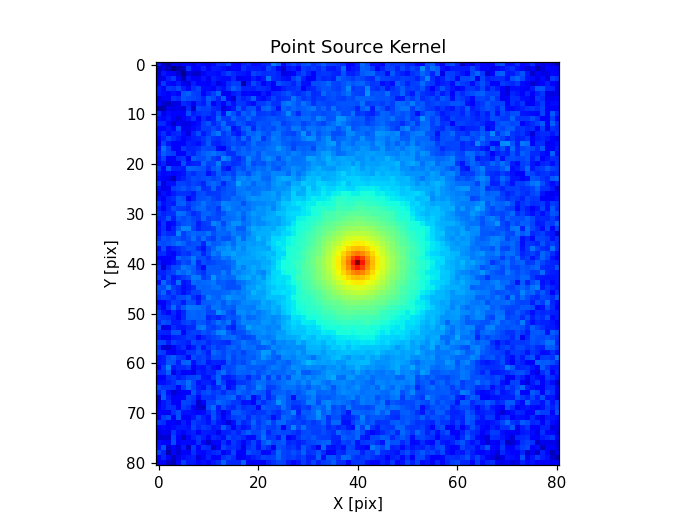

In [284]:
fig = plt.figure()
ax = fig.add_subplot(111)

kernel.get_plot(ax)

In [ ]:
# Lets make a fake setup
# Very high res and then I'll bin it
# Then I'll convolve it

In [457]:
high_res = np.zeros([1024*4,1024])

h,w = high_res.shape

Y, X = np.mgrid[:h, :w]

dist_from_line = np.abs((X - high_res.shape[1]/2) + Y*tan(2.3*pi/180))

mask = dist_from_line < (14.298)

high_res[mask] = 1

In [458]:
# 14 = 0.3 mm 
pp = 0.3*1/cos(2.3*pi/180)/14.298 # per pixel
0.336/ pp

16.00085923670791

In [459]:
pitch = 0.336
n_pix = (0.3*1/cos(2.3*pi/180))/32

print(n_pix)

0.009382558635075413


<IPython.core.display.Javascript object>


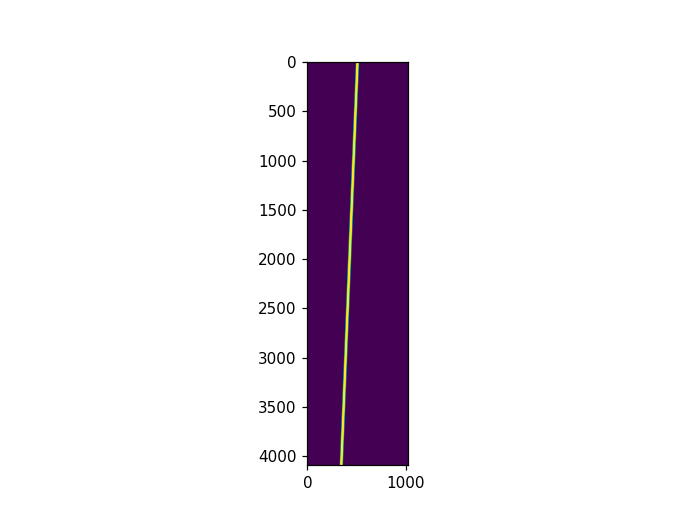

In [460]:
plt.figure()
plt.imshow(high_res)

In [461]:
step = 16*2
low_res = [[np.mean(high_res[ii:ii+step,jj:jj+step]) for ii in range(0,h,step)] for jj in range(0,w,step)]

<IPython.core.display.Javascript object>


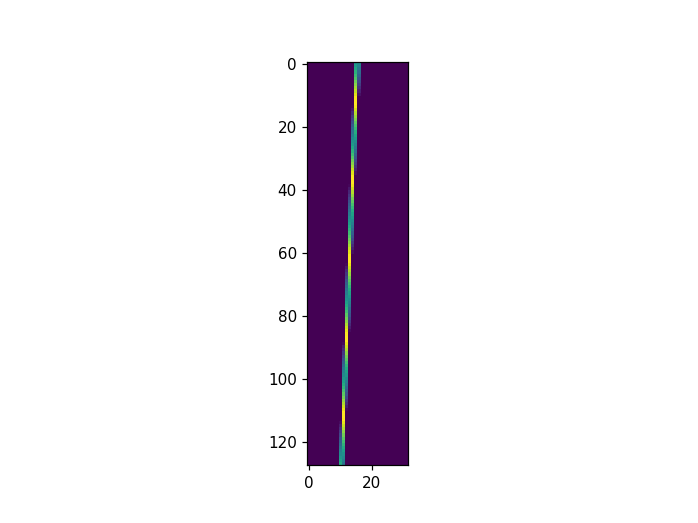

In [462]:
plt.figure()
plt.imshow(np.array(low_res).T)

In [463]:
from scipy.ndimage import convolve

In [464]:
low_res = np.array(low_res).T

lsf_image = convolve(low_res,kernel.kernel/np.sum(kernel.kernel))

<IPython.core.display.Javascript object>


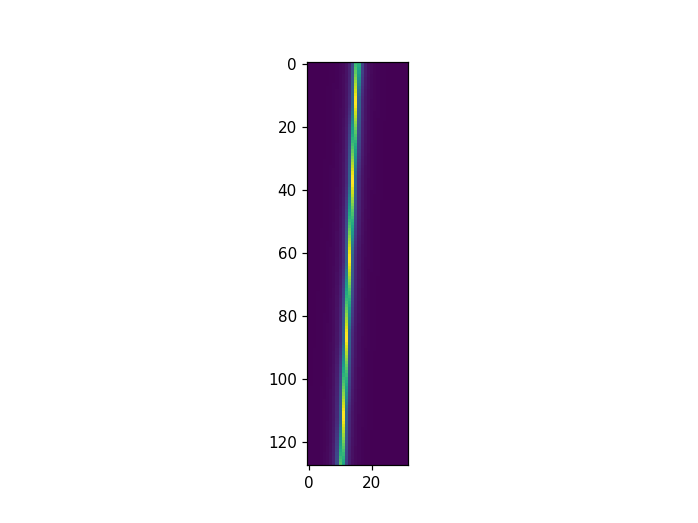

In [465]:
plt.figure()
plt.imshow(lsf_image)

In [466]:
plt.close('all')

In [467]:
h,w = lsf_image.shape

pad_len = int((512 - w)/2)

lsf_image =  np.pad(lsf_image,((0,0),(pad_len,pad_len)),mode='constant')

h,w = lsf_image.shape

Y, X = np.mgrid[:h, :w]

center = int(w/2)

dist_from_line = X + Y*tan(2.3*pi/180)

<IPython.core.display.Javascript object>


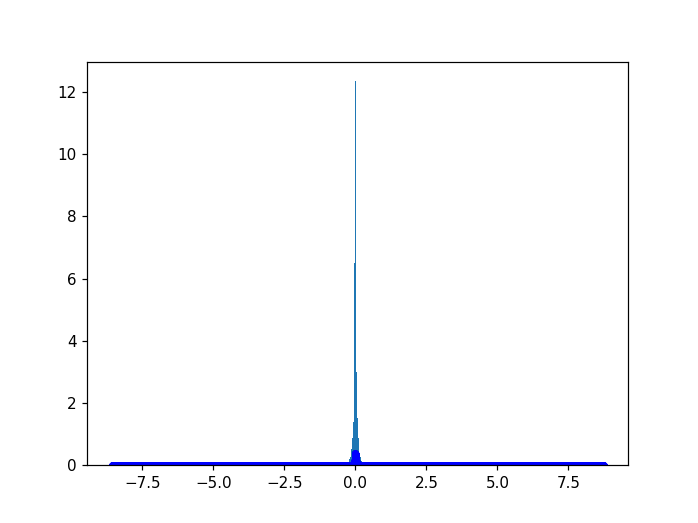

In [468]:
plt.figure()
plt.plot((dist_from_line[10:-10,:] - center + 0.5)*0.0336,lsf_image[10:-10,:],'b.');

In [469]:
dist_from_line = (dist_from_line - center + 0.5)*0.0336

inds = np.argsort(dist_from_line[10:-10,:].flatten())
line = dist_from_line[10:-10,:].flatten()[inds]
lsf = lsf_image[10:-10,:].flatten()[inds]

In [538]:
n,bins,patches = plt.hist(line,818,weights=lsf,density=True)

In [539]:
# np.save('full_bins',bins2)

In [540]:
n2 = np.load('full_n.npy')
bins2 = np.load('full_bins.npy')

<IPython.core.display.Javascript object>


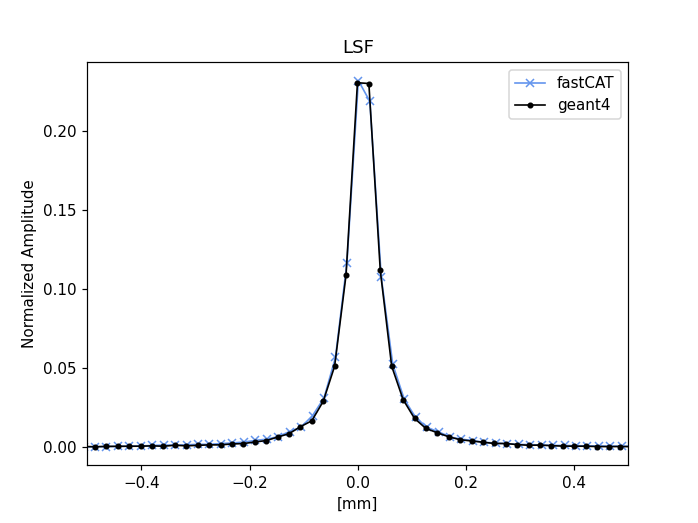

In [541]:
plt.figure()
plt.plot(bins[1:],n/(np.sum(n)),'x-',linewidth= 1.1,markersize=5,color='cornflowerblue')
plt.plot(bins2[1:],n2/np.sum(n2),'ko-',linewidth= 1.1,markersize=3)
plt.title('LSF')
plt.legend(['fastCAT','geant4'])
plt.xlabel('[mm]')
plt.ylabel('Normalized Amplitude')
plt.xlim([-0.5,0.5])
plt.savefig('LSF_good')

<IPython.core.display.Javascript object>


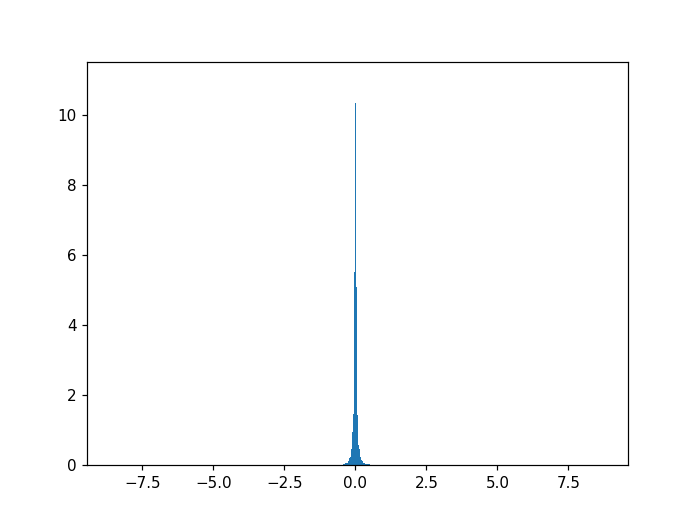

<IPython.core.display.Javascript object>


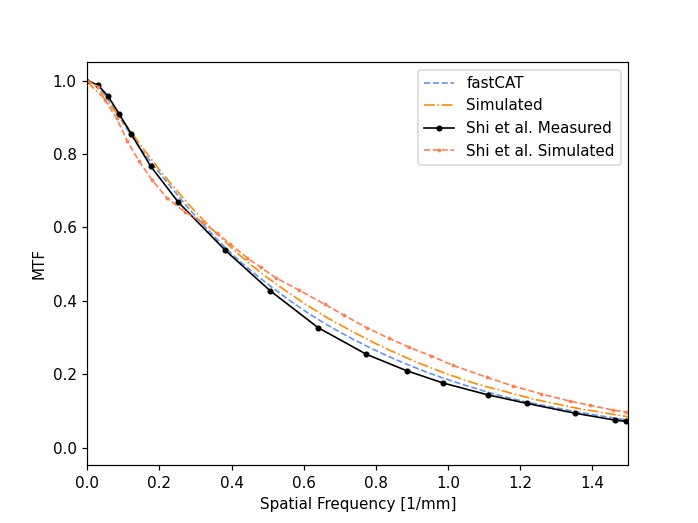

In [561]:
for ii in [818]:
    plt.figure()
    n,bins,patches = plt.hist(line,ii,weights=lsf,density=True)

    mtf = np.absolute(np.fft.fft(n))
    mtf_final = np.fft.fftshift(mtf)

    N = len(mtf)

    T = np.mean(np.diff(bins))

    xf = np.linspace(0.0, 1.0/(2.0*T), int((N-1)/2))

    mm = np.argmax(mtf_final)

    plt.figure()
    plt.plot(xf/10,mtf_final[mm+1:]/mtf_final[mm+1],'--',linewidth= 1.1,markersize=2,color='cornflowerblue')
#     plt.legend([])
    # plt.xlim([0,15])

    shi_data = [-0.0036600255852107244, 0.9985732893897139,
    0.028883896178828306, 0.9869637814824851,
    0.05821655345648036, 0.9552964008777066,
    0.08921020960640147, 0.9064175751164883,
    0.1218386383306087, 0.8532306428065635,
    0.17567540002389503, 0.7655438897096748,
    0.25229698659836164, 0.6677232950720785,
    0.38264460160796343, 0.5366967103480229,
    0.5064443842210934, 0.42720366468803805,
    0.6399828654853176, 0.326270882689769,
    0.7734630660873568, 0.25401218648646273,
    0.8857495038858628, 0.20908478962137955,
    0.9866304160947875, 0.17567598283051677,
    1.1102728409200182, 0.14360296881693158,
    1.2192635072719695, 0.1201951236569948,
    1.3510244283395543, 0.09382195840509122,
    1.4632584135420945, 0.07470123875547463,
    1.4925327901575614, 0.07170794394565894]
    
    shi_data_sim = [0, 1.0028606704405152,
    0.03089430894308942, 0.9856244321755537,
    0.04878048780487804, 0.9497821883662961,
    0.08130081300813002, 0.8995923311668645,
    0.11056910569105688, 0.8379458149882357,
    0.14308943089430892, 0.7834579635194632,
    0.1788617886178861, 0.7318307824912058,
    0.22113821138211376, 0.6816269480746382,
    0.26991869918699185, 0.6443077783213361,
    0.31707317073170727, 0.6170195913993523,
    0.36097560975609744, 0.5854380692804062,
    0.3967479674796748, 0.5553008595988538,
    0.4439024390243902, 0.517984019381741,
    0.4813008130081301, 0.4921424744333402,
    0.5235772357723576, 0.46342861136347735,
    0.5869918699186991, 0.43038647005381225,
    0.6585365853658535, 0.39160202203741235,
    0.7121951219512195, 0.36143918745777703,
    0.7756097560975608, 0.32696438139166484,
    0.8373983739837396, 0.2982225638875299,
    0.8926829268292682, 0.27378805879749335,
    0.9528455284552844, 0.25077922985533563,
    1.0130081300813008, 0.22490507140028415,
    1.1089430894308943, 0.19181633936683207,
    1.1788617886178858, 0.16879353320753832,
    1.2569105691056908, 0.1471917441237448,
    1.3382113821138208, 0.12701796072401972,
    1.3934959349593494, 0.11547743844200609,
    1.4585365853658534, 0.10249027418640944,
    1.4943089430894305, 0.09670836536445593]

    shi_sim_x = shi_data_sim[::2]
    shi_sim_y = shi_data_sim[1::2]

    shi_x = shi_data[::2]
    shi_y = shi_data[1::2]

    
    mtf = np.absolute(np.fft.fft(n2))
    mtf_final = np.fft.fftshift(mtf)

    N = len(mtf)

    T = np.mean(np.diff(bins2))

    xf = np.linspace(0.0, 1.0/(2.0*T), int((N-1)/2))

    mm = np.argmax(mtf_final)

    plt.plot(xf/10,mtf_final[mm+1:]/mtf_final[mm+1],'-.',linewidth= 1.1,markersize=2,color='darkorange')
    
#     plt.plot(star_x,np.array(star_y)/star_y[0])
    plt.plot(shi_x,np.array(shi_y)/shi_y[0],'ko-',linewidth= 1.1,markersize=3)
    plt.plot(shi_sim_x,np.array(shi_sim_y)/shi_sim_y[0],'.--',linewidth= 1.1,markersize=3,color='coral')

    plt.legend(['fastCAT','Simulated','Shi et al. Measured','Shi et al. Simulated'])
    plt.xlim((0,1.5))
    plt.xlabel('Spatial Frequency [1/mm]')
    plt.ylabel('MTF')
    plt.savefig('Shi_Comparison_good')

In [260]:
center = int(kernel.kernel.shape[0]/2)
lsf = kernel.kernel[center,:]

N = kernel.kernel.shape[0]

# if N < 40:
# T = 0.784
# else:
T = 0.336

xf = np.linspace(0.0, 1.0/(2.0*T), int(N/2))

mtf = np.absolute(np.fft.fft(lsf))
mtf_final = np.fft.fftshift(mtf)

nn = 0

fig = plt.figure(1)
place = fig.add_subplot(111)
place.plot(xf[:center-nn],mtf_final[center:center + center-nn]/mtf_final[center+2])
place.set_title('MTF from Kernel')
place.set_xlabel('Spacial Frequency [1/mm]')
place.set_ylabel('MTF')
place.grid()

shi_data = [-0.0036600255852107244, 0.9985732893897139,
0.028883896178828306, 0.9869637814824851,
0.05821655345648036, 0.9552964008777066,
0.08921020960640147, 0.9064175751164883,
0.1218386383306087, 0.8532306428065635,
0.17567540002389503, 0.7655438897096748,
0.25229698659836164, 0.6677232950720785,
0.38264460160796343, 0.5366967103480229,
0.5064443842210934, 0.42720366468803805,
0.6399828654853176, 0.326270882689769,
0.7734630660873568, 0.25401218648646273,
0.8857495038858628, 0.20908478962137955,
0.9866304160947875, 0.17567598283051677,
1.1102728409200182, 0.14360296881693158,
1.2192635072719695, 0.1201951236569948,
1.3510244283395543, 0.09382195840509122,
1.4632584135420945, 0.07470123875547463,
1.4925327901575614, 0.07170794394565894]

shi_x = shi_data[::2]
shi_y = shi_data[1::2]

star_data = [0.0043086409992885155, 0.9784172661870504,
0.07416396553087196, 0.8705035971223021,
0.17022689540675146, 0.7248201438848921,
0.2729860067989565, 0.6025179856115108,
0.3736105620997708, 0.4946043165467626,
0.4502174084907898, 0.42266187050359716,
0.5312593880939205, 0.3597122302158273,
0.6364455688196695, 0.289568345323741,
0.7394971934540282, 0.23381294964028776,
0.8491659419716973, 0.1834532374100719,
0.9786465333227923, 0.14028776978417268,
1.1191240414261996, 0.09892086330935257,
1.2442801802514032, 0.07194244604316546,
1.2904024033520434, 0.06474820143884896]

star_x = star_data[::2]
star_y = star_data[1::2]

plt.plot(shi_x,shi_y)
plt.plot(star_x,star_y)

/home/xcite/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


<IPython.core.display.Javascript object>


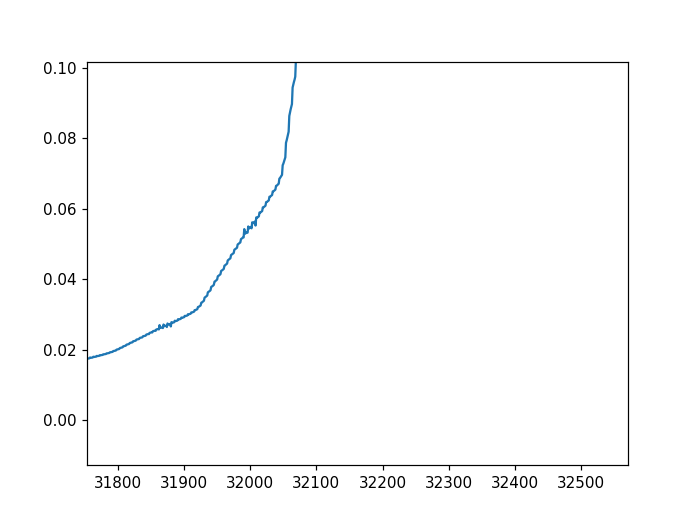

In [73]:
plt.figure()
plt.plot(lsf)

In [62]:
kernel.kernel.shape

(81, 81)

<IPython.core.display.Javascript object>


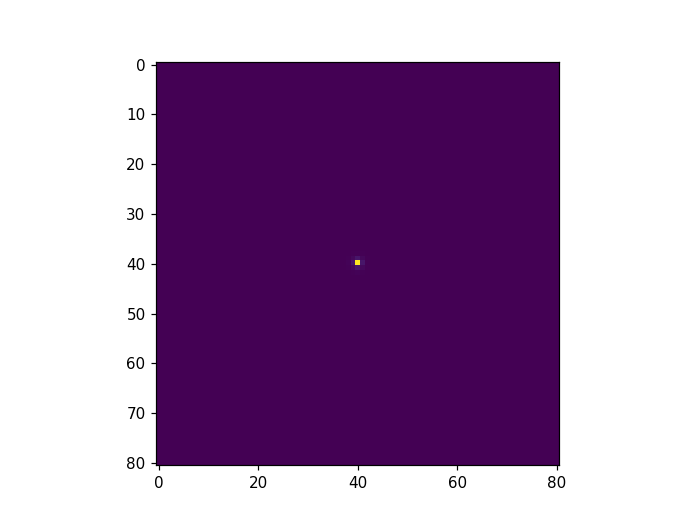

In [63]:
plt.figure()
plt.imshow(kernel.kernel)